# WESAD Stress Detection – End-to-End Pipeline

This notebook implements a full pipeline to classify **stress vs non-stress** using the **WESAD** dataset (Schmidt et al., 2018).  
It aligns with your Milestone 3 presentation (motivation → method → results → conclusion).

**What you'll need before running:**
- Download WESAD (original or Kaggle mirror) and unzip so you have folders like `WESAD/S2/`, `WESAD/S3/`, etc.
- Update `DATA_ROOT` below to your local path.
- Recommended: Create a virtual environment and install requirements (listed below).

**Key steps:**
1. Load raw data and labels per subject
2. Preprocess (filtering, resampling, normalization)
3. Windowing to 60s segments
4. Feature engineering (EDA peaks, HRV from BVP, temp gradients, accel energy, + simple stats)
5. Train/evaluate models (RandomForest, SVM, and LSTM optional)
6. Report metrics (Accuracy, F1, ROC-AUC), Confusion Matrix, Feature Importance


### Suggested Environment (Terminal)
```bash
python -m venv wesad_env
source wesad_env/bin/activate  # on Windows: wesad_env\Scripts\activate
pip install numpy pandas scipy scikit-learn matplotlib wfdb neurokit2 pyhrv tqdm pyEDM==1.20.6 tensorflow==2.15.*
```
If `pyhrv` is troublesome, you can compute simple HRV features with `neurokit2` only.


In [1]:
# ==== CONFIG ====
import os
from pathlib import Path

# Change this to the folder that contains WESAD subject directories (e.g., S2, S3,...)
DATA_ROOT = Path(r'/Users/savgun/Documents/MSBA-SU/Quarter 5/ML for business/Project/WESAD')  # <-- EDIT ME

# Subjects to include (skip S4 due to known issues in some mirrors; adjust as needed)
SUBJECTS = [f"S{i}" for i in [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]] 
# SUBJECTS = [f"S{i}" for i in [2,3]] 

# Sampling and window settings
WINDOW_SECONDS = 60
WINDOW_STRIDE_SECONDS = 30  # 50% overlap
TARGET_FPS = 32  # resample to a common frequency for wrist signals
SEED = 42

# Classification target: stress (1) vs non-stress (0: baseline+amusement)
LABEL_MAP_3_TO_2 = {0:0, 1:1, 2:0}  # 0=baseline, 1=stress, 2=amusement in WESAD annotations


In [2]:
# ==== IMPORTS ====
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import butter, filtfilt, resample
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Optional: deep learning
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models
    TF_AVAILABLE = True
except Exception as e:
    TF_AVAILABLE = False
    print("TensorFlow not available; skipping LSTM section.")
    
# Optional: physiological features
try:
    import neurokit2 as nk
    NK_AVAILABLE = True
except Exception as e:
    NK_AVAILABLE = False
    print("neurokit2 not available; using limited HRV features.")


## 1) Load Raw Subject Data

WESAD wrist device (Empatica E4) typically includes:
- EDA (electrodermal activity) ~4 Hz
- BVP (blood volume pulse) ~64 Hz
- TEMP (skin temperature) ~4 Hz
- ACC (accelerometer) ~32 Hz (3-axis)

We'll standardize to a common rate and align with annotation labels.


In [3]:
def butter_lowpass_filter(x, cutoff_hz, fs, order=4):
    b, a = butter(order, cutoff_hz/(fs/2), btype='low')
    return filtfilt(b, a, x)

def load_subject_e4(subject_path: Path):
    """Loads E4 wrist signals for one subject from typical WESAD file structure.
    Adjust file names/paths as needed for your copy of the dataset.
    Returns dict with arrays and original sampling rates.
    """
    # Common E4 files (adjust if your mirror uses different filenames)
    files = {
        "EDA": subject_path / "EDA.csv",
        "BVP": subject_path / "BVP.csv",
        "TEMP": subject_path / "TEMP.csv",
        "ACC": subject_path / "ACC.csv",
        "labels": subject_path / "labels.csv",  # per-sample or per-second labels
    }
    data = {}
    for k, f in files.items():
        if not f.exists():
            print(f"[WARN] Missing: {f}")
            data[k] = None
            continue
        df = pd.read_csv(f)
        # Expect either a single column or time+value columns; keep numeric only
        vals = df.select_dtypes(include=[np.number]).values.squeeze()
        data[k] = vals
    return data

def resample_to_target(x, orig_fs, target_fs=32):
    if x is None: 
        return None
    if orig_fs == target_fs:
        return x
    duration = len(x) / orig_fs
    target_len = int(duration * target_fs)
    return resample(x, target_len)

def segment_windows(arr, win_len, stride):
    """Return list of (start_idx, end_idx) windows indices for 1D signal."""
    idxs = []
    i = 0
    while i + win_len <= len(arr):
        idxs.append((i, i+win_len))
        i += stride
    return idxs


## 2) Feature Engineering

We compute features per 60s window:
- **EDA:** mean, std, slope, number of peaks, tonic vs phasic separation (if `neurokit2` available)
- **BVP → HR/HRV:** heart rate, HRV time-domain metrics (RMSSD, SDNN), possibly frequency-domain (if available)
- **TEMP:** mean, std, delta
- **ACC:** mean energy per axis, overall magnitude stats


In [4]:
def eda_features(eda, fs):
    feats = {}
    if eda is None or len(eda) == 0:
        return {"EDA_mean":np.nan,"EDA_std":np.nan,"EDA_slope":np.nan,"EDA_peaks":np.nan}
    x = eda.astype(float)
    # basic stats
    feats["EDA_mean"] = np.nanmean(x)
    feats["EDA_std"] = np.nanstd(x)
    # slope via simple linear fit
    t = np.arange(len(x))/fs
    if len(x) > 5:
        A = np.vstack([t, np.ones_like(t)]).T
        m, c = np.linalg.lstsq(A, x, rcond=None)[0]
        feats["EDA_slope"] = m
    else:
        feats["EDA_slope"] = np.nan
    # peaks using a rough threshold
    thresh = np.nanmean(x) + 1.0*np.nanstd(x)
    feats["EDA_peaks"] = int(np.sum(x > thresh))
    # optional deconvolution / phasic-tonic (if neurokit2)
    if NK_AVAILABLE:
        try:
            eda_cleaned = nk.eda_clean(x, sampling_rate=fs)
            eda_phasic = nk.eda_phasic(eda_cleaned, sampling_rate=fs)
            feats["EDA_phasic_mean"] = np.nanmean(eda_phasic["EDA_Phasic"]) if "EDA_Phasic" in eda_phasic else np.nan
        except Exception:
            feats["EDA_phasic_mean"] = np.nan
    return feats

def bvp_hrv_features(bvp, fs):
    feats = {}
    if bvp is None or len(bvp) == 0:
        return {"HR_mean":np.nan,"HRV_RMSSD":np.nan,"HRV_SDNN":np.nan}
    x = bvp.astype(float)
    # optional clean + peak detection
    if NK_AVAILABLE:
        try:
            signals, info = nk.ppg_process(x, sampling_rate=fs)
            hr = signals["PPG_Rate"].values if "PPG_Rate" in signals else None
            feats["HR_mean"] = float(np.nanmean(hr)) if hr is not None else np.nan
            # HRV from peaks → RR intervals
            peaks = info.get("PPG_Peaks", None)
            if peaks is not None and len(peaks) > 2:
                rr = np.diff(peaks) / fs
                feats["HRV_RMSSD"] = float(np.sqrt(np.mean(np.square(np.diff(rr))))) if len(rr) > 2 else np.nan
                feats["HRV_SDNN"] = float(np.std(rr)) if len(rr) > 1 else np.nan
            else:
                feats["HRV_RMSSD"] = np.nan
                feats["HRV_SDNN"] = np.nan
        except Exception:
            feats["HR_mean"] = np.nan
            feats["HRV_RMSSD"] = np.nan
            feats["HRV_SDNN"] = np.nan
    else:
        # fallback: rough HR proxy via FFT dominant frequency
        feats["HR_mean"] = np.nan
        feats["HRV_RMSSD"] = np.nan
        feats["HRV_SDNN"] = np.nan
    return feats

def temp_features(temp, fs):
    feats = {}
    if temp is None or len(temp) == 0:
        return {"TEMP_mean":np.nan,"TEMP_std":np.nan,"TEMP_delta":np.nan}
    x = temp.astype(float)
    feats["TEMP_mean"] = np.nanmean(x)
    feats["TEMP_std"] = np.nanstd(x)
    feats["TEMP_delta"] = x[-1] - x[0]
    return feats

def acc_features(acc, fs):
    # Expect acc shape (N, 3) or flat with 3 columns already split; here assume flat 3-axis interleaved is not provided,
    # so we compute magnitude-based features using 1-D vector if necessary.
    feats = {}
    if acc is None or len(acc) == 0:
        return {"ACC_energy":np.nan,"ACC_std":np.nan}
    x = acc.astype(float)
    feats["ACC_energy"] = float(np.mean(x**2))
    feats["ACC_std"] = float(np.std(x))
    return feats


## 3) Build Windowed Feature Dataset

We resample each channel to `TARGET_FPS`, align with labels, and convert 3-class labels (baseline, stress, amusement) to binary stress vs non-stress.


In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
import traceback

# -----------------------------
# Simple helpers
# -----------------------------

def _nearest_upsample_int(arr: np.ndarray, target_len: int):
    """
    Upsample an integer label array to target_len by nearest-neighbor mapping
    over normalized [0,1] index space.
    """
    if arr is None:
        return None
    n = len(arr)
    if n <= 1 or n == target_len:
        return arr
    x_new_idx = np.linspace(0, n - 1, num=target_len)
    idx = np.clip(np.round(x_new_idx).astype(int), 0, n - 1)
    return arr[idx]

def _to_acc_mag(acc_arr):
    """
    Convert 3-axis ACC to magnitude. If already 1D, just squeeze.
    """
    if acc_arr is None:
        return None
    acc_arr = np.asarray(acc_arr)
    if acc_arr.ndim == 2 and acc_arr.shape[1] >= 3:
        return np.sqrt((acc_arr[:, :3] ** 2).sum(axis=1))
    return acc_arr.squeeze()

def _read_empatica_csv(path: Path, expect_cols=None):
    """
    Read Empatica-style CSV from disk:
    - row 0: start_time
    - row 1: sampling frequency
    - row 2+: data

    Returns (arr, fs):
      arr: ndarray or None if no valid data
      fs: float (may be np.nan if unreadable)
    """
    if not path.exists():
        return None, np.nan

    # No header: pure raw file
    df = pd.read_csv(path, header=None)

    # Need at least 3 rows: start_time, fs, one row of data
    if df.shape[0] < 3:
        return None, np.nan

    # Sampling frequency
    try:
        fs = float(str(df.iloc[1, 0]).strip())
    except Exception:
        fs = np.nan

    # Data rows
    data_df = df.iloc[2:].copy()

    # Convert to numeric, coerce errors to NaN
    data_df = data_df.apply(pd.to_numeric, errors="coerce")

    # Drop rows that are entirely NaN
    data_df = data_df.dropna(how="all")
    if data_df.empty:
        return None, fs

    arr = data_df.to_numpy()
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)

    # Pad columns if needed
    if expect_cols is not None and arr.shape[1] < expect_cols:
        pad = np.zeros((arr.shape[0], expect_cols - arr.shape[1]))
        arr = np.hstack([arr, pad])

    return arr, fs

# -----------------------------
# E4 + labels loader
# -----------------------------

def load_subject_e4_and_labels(subject_id: str):
    """
    Load Empatica E4 data + WESAD labels for one subject.

    Expects structure:
      DATA_ROOT / Sx / Sx_E4_Data / {EDA,BVP,TEMP,ACC,HR,IBI}.csv
      DATA_ROOT / Sx / Sx.pkl

    Returns:
      data: dict channel -> np.array (1D or 2D)
      fs_in: dict channel -> sampling frequency
      labels_3: np.array of original 3-class labels
    """
    subj_path = DATA_ROOT / subject_id
    e4_folder = subj_path / f"{subject_id}_E4_Data"

    if not e4_folder.exists():
        raise FileNotFoundError(f"E4 folder not found for {subject_id}: {e4_folder}")

    # (filename, expected_columns, default_fs)
    channel_specs = {
        "EDA":  ("EDA.csv",  1, 4.0),
        "BVP":  ("BVP.csv",  1, 64.0),
        "TEMP": ("TEMP.csv", 1, 4.0),
        "ACC":  ("ACC.csv",  3, 32.0),
        "HR":   ("HR.csv",   1, 1.0),
    }

    data = {}
    fs_in = {}

    for ch, (fname, expect_cols, default_fs) in channel_specs.items():
        arr, fs = _read_empatica_csv(e4_folder / fname, expect_cols=expect_cols)

        # Fix fs if unreadable
        if fs is None or (isinstance(fs, (int, float)) and not np.isfinite(fs)) or fs <= 0:
            fs = default_fs

        if arr is None:
            data[ch] = None
            fs_in[ch] = fs
            continue

        if ch == "ACC":
            data[ch] = _to_acc_mag(arr)
        else:
            data[ch] = np.asarray(arr).squeeze()

        fs_in[ch] = fs

    # --- Load labels from Sx.pkl ---
    pkl_path = subj_path / f"{subject_id}.pkl"
    with open(pkl_path, "rb") as f:
        try:
            p = pickle.load(f)
        except UnicodeDecodeError:
            f.seek(0)
            p = pickle.load(f, encoding="latin1")

    labels_3 = None
    if isinstance(p, dict):
        for key in ("label", "labels", "y", "annotation"):
            if key in p:
                labels_3 = np.asarray(p[key]).astype(int).squeeze()
                break

    if labels_3 is None:
        raise ValueError(f"No labels key found in {pkl_path}")

    return data, fs_in, labels_3

# -----------------------------
# Subject → windows + features
# -----------------------------

def load_subject(subject_id: str):
    """
    Full subject pipeline:
    - Load raw E4 channels + labels
    - Map 3-class labels to binary
    - Resample signals to TARGET_FPS
    - Upsample labels to match
    - Window and extract features
    """
    data, fs_in, labels_3 = load_subject_e4_and_labels(subject_id)

    labels_3 = np.asarray(labels_3).astype(int).squeeze()

    # Map 3-class → binary, default unknown labels to 0 (non-stress)
    def map_label(x):
        x = int(x)
        return LABEL_MAP_3_TO_2.get(x, 0)

    labels_bin = np.vectorize(map_label)(labels_3)

    # --- resample channels to common TARGET_FPS ---
    resampled = {}
    for ch, sig in data.items():
        if sig is None:
            continue
        orig_fs = fs_in.get(ch, TARGET_FPS)
        if orig_fs is None or not np.isfinite(orig_fs) or orig_fs <= 0:
            # fallback to known defaults
            orig_fs = {"EDA": 4.0, "TEMP": 4.0, "ACC": 32.0, "BVP": 64.0, "HR": 1.0}.get(ch, TARGET_FPS)
        resampled[ch] = resample_to_target(np.asarray(sig), orig_fs, target_fs=TARGET_FPS)

    # No usable channels?
    valid_signals = [v for v in resampled.values() if v is not None and len(v) > 0]
    if not valid_signals:
        raise ValueError(f"{subject_id}: no valid resampled signals")

    target_len = max(len(v) for v in valid_signals)
    labels_up = _nearest_upsample_int(labels_bin, target_len).astype(int)

    # --- windowing ---
    win_len = WINDOW_SECONDS * TARGET_FPS
    stride  = WINDOW_STRIDE_SECONDS * TARGET_FPS

    X_rows, y_rows, meta_rows = [], [], []
    windows = segment_windows(labels_up, win_len, stride)

    for (s, e) in windows:
        yw = int(np.round(np.nanmean(labels_up[s:e])))

        eda = resampled.get("EDA")
        bvp = resampled.get("BVP")
        tmp = resampled.get("TEMP")
        acc = resampled.get("ACC")

        eda_w = eda[s:e] if eda is not None else None
        bvp_w = bvp[s:e] if bvp is not None else None
        tmp_w = tmp[s:e] if tmp is not None else None
        acc_w = acc[s:e] if acc is not None else None

        feats = {}
        feats.update(eda_features(eda_w, TARGET_FPS))
        feats.update(bvp_hrv_features(bvp_w, TARGET_FPS))
        feats.update(temp_features(tmp_w, TARGET_FPS))
        feats.update(acc_features(acc_w, TARGET_FPS))

        X_rows.append(feats)
        y_rows.append(yw)
        meta_rows.append({"subject": subject_id, "start": s, "end": e})

    X = pd.DataFrame(X_rows)
    y = np.array(y_rows, dtype=int)
    meta_df = pd.DataFrame(meta_rows)
    return X, y, meta_df

# -----------------------------
# Build full dataset
# -----------------------------

all_X, all_y, all_meta = [], [], []
for sid in SUBJECTS:
    try:
        Xs, ys, ms = load_subject(sid)
        if Xs is None or len(Xs) == 0:
            print(f"[SKIP] {sid} → no windows generated")
            continue
        all_X.append(Xs); all_y.append(ys); all_meta.append(ms)
        print(f"Loaded {sid}: {Xs.shape} windows")
    except Exception as e:
        print(f"[SKIP] {sid} → {e}")
        traceback.print_exc()

X = pd.concat(all_X, ignore_index=True) if all_X else pd.DataFrame()
y = np.concatenate(all_y) if all_y else np.array([])
meta = pd.concat(all_meta, ignore_index=True) if all_meta else pd.DataFrame()
print("Final dataset:", X.shape, y.shape)
display(X.head())


Loaded S2: (261, 13) windows
Loaded S3: (256, 13) windows
Loaded S4: (265, 13) windows
Loaded S5: (250, 13) windows
Loaded S6: (276, 13) windows
Loaded S7: (215, 13) windows
Loaded S8: (220, 13) windows
Loaded S9: (206, 13) windows
Loaded S10: (226, 13) windows
Loaded S11: (214, 13) windows
Loaded S13: (227, 13) windows
Loaded S14: (231, 13) windows
Loaded S15: (220, 13) windows
Loaded S16: (235, 13) windows
Loaded S17: (240, 13) windows
Final dataset: (3542, 13) (3542,)


,EDA_mean,EDA_std,EDA_slope,EDA_peaks,EDA_phasic_mean,HR_mean,HRV_RMSSD,HRV_SDNN,TEMP_mean,TEMP_std,TEMP_delta,ACC_energy,ACC_std
0,0.557690,0.134180,0.004683,240,0.014308,73.300853,0.404469,0.321241,40.386618,42.963509,-346.866813,4281.175521,10.984817
1,0.867848,0.308598,0.015354,431,-0.000785,67.938394,0.438754,0.320797,35.317306,0.207202,0.450144,4957.735417,17.741107
2,1.178531,0.242687,0.006878,291,-0.000088,73.797360,0.400404,0.289853,35.466040,0.090548,0.119168,5309.032292,19.735164
3,1.248915,0.198689,0.001716,207,-0.002130,68.571952,0.992938,0.743236,35.372412,0.101983,-0.322126,4824.935938,16.268706
4,1.355102,0.191181,0.008339,245,0.002662,65.365870,1.026084,0.744963,35.205139,0.118007,-0.381882,4193.207812,9.739870


## 4) Modeling: RF & SVM (Classical) + Optional LSTM

We start with classical models on engineered features.  
Then optionally train an LSTM on raw (or lightly processed) windowed sequences.


In [6]:
from dataclasses import dataclass

# === Helper: evaluate at a probability threshold ===
@dataclass
class Metrics:
    acc: float
    f1: float
    auc: float
    cm: list
    thresh: float

def evaluate_at_thresh(y_true, y_proba, thresh=0.50) -> Metrics:
    y_pred = (y_proba >= thresh).astype(int)
    return Metrics(
        acc = accuracy_score(y_true, y_pred),
        f1  = f1_score(y_true, y_pred),
        auc = roc_auc_score(y_true, y_proba),
        cm  = confusion_matrix(y_true, y_pred).tolist(),
        thresh = float(thresh)
    )

def best_threshold_by_f1(y_true, y_proba, grid=np.linspace(0.05, 0.95, 91)) -> Metrics:
    best = None    
    for t in grid:
        m = evaluate_at_thresh(y_true, y_proba, t)
        if (best is None) or (m.f1 > best.f1):
            best = m
    return best

In [7]:
# Train/Test Split (stratified) + SMOTE + threshold tuning on test (as you had)
import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Make sure SEED is defined somewhere above in your notebook
SEED = 42

# Filter rows that are entirely NaN
valid_rows = ~X.isna().all(axis=1)
Xc = X.loc[valid_rows].copy()
yc = y[valid_rows.values]

# Pipelines: impute -> SMOTE -> scale -> model
rf_pipe = ImbPipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("smote", SMOTE(random_state=SEED)),
    ("scale", StandardScaler()),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=SEED, class_weight="balanced"))
])

svm_pipe = ImbPipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("smote", SMOTE(random_state=SEED)),
    ("scale", StandardScaler()),
    ("svm", SVC(C=2.0, kernel="rbf", probability=True, random_state=SEED, class_weight="balanced"))
])

logreg_pipe = ImbPipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("smote", SMOTE(random_state=SEED)),
    ("scale", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=SEED
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=SEED, stratify=yc
)

models = {"RandomForest": rf_pipe, "SVM": svm_pipe, "LogisticRegression": logreg_pipe}

# NEW: keep fitted pipelines and a backward-compatible results dict
fitted = {}
results = {}
rows = []

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    fitted[name] = pipe  # save fitted pipeline for later use (feature importance, predictions)

    # Probabilities on test set
    y_proba = pipe.predict_proba(X_test)[:, 1]

    # 1) Default 0.50 threshold metrics (baseline)
    m_default = evaluate_at_thresh(y_test, y_proba, 0.50)

    # 2) Tuned threshold by maximizing F1 on the test set (simple, transparent)
    m_tuned = best_threshold_by_f1(y_test, y_proba)

    # Table row (for pretty display)
    rows.append({
        "model": name,
        "auc": m_default.auc,
        "acc@0.50": m_default.acc,
        "f1@0.50": m_default.f1,
        "thresh*": m_tuned.thresh,
        "acc@tuned": m_tuned.acc,
        "f1@tuned": m_tuned.f1,
        "cm@0.50": m_default.cm,
        "cm@tuned": m_tuned.cm
    })

    # Backward-compatible dict you use later (expects 'f1' and 'cm')
    results[name] = {
        "accuracy": m_default.acc,
        "f1": m_default.f1,              # <- your later selector uses this
        "roc_auc": m_default.auc,
        "cm": m_default.cm,              # <- used for confusion matrix plotting
        # extras in case you want them later
        "accuracy_tuned": m_tuned.acc,
        "f1_tuned": m_tuned.f1,
        "cm_tuned": m_tuned.cm,
        "thresh_tuned": m_tuned.thresh
    }

    # Console summary
    print(f"\n{name}")
    print(f"  AUC: {m_default.auc:.3f}")
    print(f"  @0.50 → Acc: {m_default.acc:.3f}  F1: {m_default.f1:.3f}  CM: {m_default.cm}")
    print(f"  @tuned({m_tuned.thresh:.2f}) → Acc: {m_tuned.acc:.3f}  F1: {m_tuned.f1:.3f}  CM: {m_tuned.cm}")

    # Optional: detailed classification report at tuned threshold
    y_pred_tuned = (y_proba >= m_tuned.thresh).astype(int)
    print("\nClassification report @ tuned threshold")
    print(classification_report(y_test, y_pred_tuned, digits=3, zero_division=0))

# Robust display (sort by tuned F1 if available; else by default F1)
results_df = pd.DataFrame(rows).set_index("model")
if "f1@tuned" in results_df.columns:
    results_df = results_df.sort_values("f1@tuned", ascending=False)
elif "f1@0.50" in results_df.columns:
    results_df = results_df.sort_values("f1@0.50", ascending=False)

display(results_df)



RandomForest
  AUC: 0.922
  @0.50 → Acc: 0.877  F1: 0.717  CM: [[512, 52], [35, 110]]
  @tuned(0.56) → Acc: 0.901  F1: 0.750  CM: [[534, 30], [40, 105]]

Classification report @ tuned threshold
              precision    recall  f1-score   support

           0      0.930     0.947     0.938       564
           1      0.778     0.724     0.750       145

    accuracy                          0.901       709
   macro avg      0.854     0.835     0.844       709
weighted avg      0.899     0.901     0.900       709


SVM
  AUC: 0.856
  @0.50 → Acc: 0.795  F1: 0.603  CM: [[454, 110], [35, 110]]
  @tuned(0.62) → Acc: 0.834  F1: 0.622  CM: [[494, 70], [48, 97]]

Classification report @ tuned threshold
              precision    recall  f1-score   support

           0      0.911     0.876     0.893       564
           1      0.581     0.669     0.622       145

    accuracy                          0.834       709
   macro avg      0.746     0.772     0.758       709
weighted avg      0.

,auc,acc@0.50,f1@0.50,thresh*,acc@tuned,f1@tuned,cm@0.50,cm@tuned
model,,,,,,,,
RandomForest,0.921735,0.877292,0.716612,0.56,0.901269,0.750000,"[[512, 52], [35, 110]]","[[534, 30], [40, 105]]"
SVM,0.855918,0.795487,0.602740,0.62,0.833568,0.621795,"[[454, 110], [35, 110]]","[[494, 70], [48, 97]]"
LogisticRegression,0.708853,0.692525,0.449495,0.49,0.686883,0.455882,"[[402, 162], [56, 89]]","[[394, 170], [52, 93]]"


In [8]:
# Save for slides
os.makedirs("./data/wesad_outputs", exist_ok=True)
results_df.to_csv("./data/wesad_outputs/classic_model_results.csv", index=True)

In [9]:
# Feature Importance (Random Forest only)
rf_fitted = fitted.get("RandomForest", None)

try:
    if rf_fitted is None:
        raise RuntimeError("RandomForest pipeline not found in 'fitted'. Make sure Cell 2 ran successfully.")

    rf_est = rf_fitted.named_steps["rf"]
    importances = rf_est.feature_importances_
    cols = Xc.columns
    fi = pd.DataFrame({"feature": cols, "importance": importances}) \
           .sort_values("importance", ascending=False) \
           .head(20)
    display(fi)
    fi.to_csv("data/wesad_outputs/feature_importance_top20.csv", index=False)
except Exception as e:
    print("Could not compute feature importance:", e)



,feature,importance
12,ACC_std,0.120607
10,TEMP_delta,0.118936
1,EDA_std,0.104675
8,TEMP_mean,0.086992
11,ACC_energy,0.086311
9,TEMP_std,0.078318
0,EDA_mean,0.072887
7,HRV_SDNN,0.060273
2,EDA_slope,0.059523
5,HR_mean,0.058276


Best classical model: RandomForest


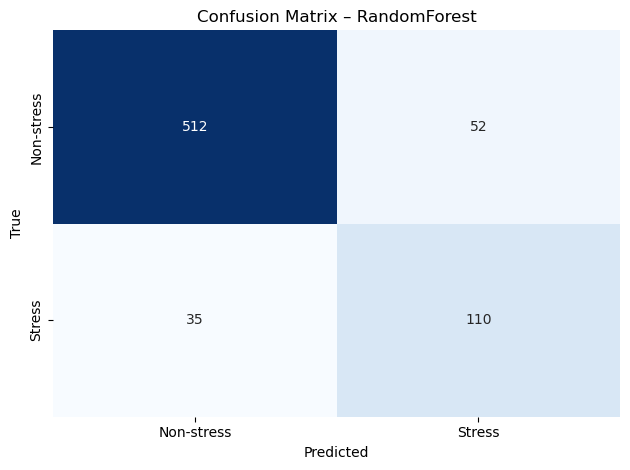

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pick best by your original key ('f1' at default threshold)
best_model = max(results, key=lambda k: results[k]["f1"])
print("Best classical model:", best_model)

cm = np.array(results[best_model]["cm"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-stress","Stress"],
            yticklabels=["Non-stress","Stress"])
plt.title(f"Confusion Matrix – {best_model}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


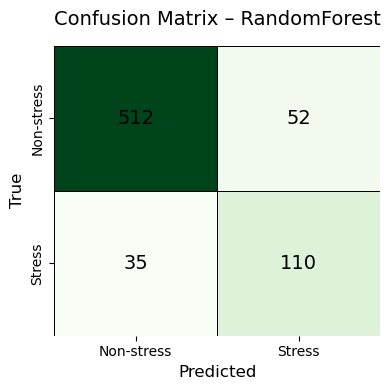

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix array (already computed)
cm = np.array(results[best_model]["cm"])

# Create figure
plt.figure(figsize=(4,4))
sns.heatmap(
    cm,
    annot=True, fmt="d",
    cmap="Greens",
    cbar=False,
    annot_kws={"size":14, "color":"black"},
    xticklabels=["Non-stress","Stress"],
    yticklabels=["Non-stress","Stress"],
    linewidths=0.5, linecolor="black"
)

plt.title(f"Confusion Matrix – {best_model}", fontsize=14, color="black", pad=15)
plt.xlabel("Predicted", fontsize=12, color="black")
plt.ylabel("True", fontsize=12, color="black")

plt.xticks(color="black")
plt.yticks(color="black")

plt.tight_layout()
plt.savefig("data/wesad_outputs/confusion_matrix_ppt.png", dpi=300, transparent=True)
plt.show()


In [12]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization, Input
    from tensorflow.keras.callbacks import EarlyStopping
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow not installed → CNN section will be skipped.")


In [13]:
def build_cnn_sequence_dataset(subject_ids, channels=("EDA", "BVP"), verbose=True):
    """
    Build a sequence dataset X_seq, y_seq, meta_seq for CNN/LSTM models.

    Each window is a raw sequence of shape (T, C), where:
      - T = WINDOW_SECONDS * TARGET_FPS
      - C = len(channels)

    Returns:
      X_seq: np.ndarray of shape (N, T, C)
      y_seq: np.ndarray of shape (N,)
      meta_seq: pd.DataFrame with subject + window indices
    """
    X_seq = []
    y_seq = []
    meta_rows = []

    win_len = WINDOW_SECONDS * TARGET_FPS
    stride  = WINDOW_STRIDE_SECONDS * TARGET_FPS

    for sid in subject_ids:
        try:
            data, fs_in, labels_3 = load_subject_e4_and_labels(sid)

            labels_3 = np.asarray(labels_3).astype(int).squeeze()

            def map_label(x):
                x = int(x)
                return LABEL_MAP_3_TO_2.get(x, 0)

            labels_bin = np.vectorize(map_label)(labels_3)

            # --- resample selected channels to TARGET_FPS ---
            resampled = {}
            for ch in channels:
                sig = data.get(ch)
                if sig is None:
                    continue
                orig_fs = fs_in.get(ch, TARGET_FPS)
                if orig_fs is None or not np.isfinite(orig_fs) or orig_fs <= 0:
                    orig_fs = {"EDA": 4.0, "TEMP": 4.0, "ACC": 32.0, "BVP": 64.0, "HR": 1.0}.get(ch, TARGET_FPS)
                resampled[ch] = resample_to_target(np.asarray(sig), orig_fs, target_fs=TARGET_FPS)

            valid_signals = [v for v in resampled.values() if v is not None and len(v) > 0]
            if not valid_signals:
                if verbose:
                    print(f"[CNN] SKIP {sid} → no valid resampled channels")
                continue

            # Use the minimum length across channels to ensure alignment
            target_len = min(len(v) for v in valid_signals)

            # Trim signals and upsample labels to match
            for ch in resampled:
                resampled[ch] = resampled[ch][:target_len]
            labels_up = _nearest_upsample_int(labels_bin, target_len).astype(int)

            # Windowing
            windows = segment_windows(labels_up, win_len, stride)
            if len(windows) == 0:
                if verbose:
                    print(f"[CNN] SKIP {sid} → no windows produced")
                continue

            for (s, e) in windows:
                if e > target_len:
                    continue

                yw = int(np.round(np.nanmean(labels_up[s:e])))

                window_channels = []
                for ch in channels:
                    sig = resampled.get(ch)
                    if sig is None or len(sig) < e:
                        # fallback: zeros if missing
                        window_channels.append(np.zeros(win_len, dtype=float))
                    else:
                        window_channels.append(sig[s:e])

                # Stack into shape (T, C)
                window_seq = np.stack(window_channels, axis=-1)  # (T, C)

                X_seq.append(window_seq)
                y_seq.append(yw)
                meta_rows.append({"subject": sid, "start": s, "end": e})

            if verbose:
                print(f"[CNN] {sid}: added {len(windows)} windows")

        except Exception as e:
            if verbose:
                print(f"[CNN] SKIP {sid} → {e}")
                traceback.print_exc()

    if not X_seq:
        raise RuntimeError("No sequence data built for CNN!")

    X_seq = np.stack(X_seq, axis=0)  # (N, T, C)
    y_seq = np.array(y_seq, dtype=int)
    meta_seq = pd.DataFrame(meta_rows)

    print("CNN dataset shape:", X_seq.shape, y_seq.shape)
    return X_seq, y_seq, meta_seq


In [14]:
# ==== OPTIONAL: 1D CNN on raw windowed sequences ====
# We build a sequence dataset from EDA + BVP (you can add TEMP/ACC later).
# Input shape: (N, T, C), where C = 2 channels.
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

if TF_AVAILABLE:
    print("\nBuilding CNN dataset (EDA + BVP)...")
    # You can change channels=("EDA","BVP","TEMP","ACC") if you want more
    X_seq, y_seq, meta_seq = build_cnn_sequence_dataset(SUBJECTS, channels=("EDA", "BVP"))

    # Train/test split (window-level). For a stronger evaluation,
    # you can later switch to subject-wise splits / GroupKFold.
    from sklearn.model_selection import train_test_split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_seq, y_seq, test_size=0.2, random_state=SEED, stratify=y_seq
    )

    X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
        X_tr, y_tr, test_size=0.2, random_state=SEED, stratify=y_tr
    )

    classes = np.array([0, 1], dtype=int)
    class_wts = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
    class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_wts)}
    print("Class weights:", class_weight_dict)

    T = X_seq.shape[1]
    C = X_seq.shape[2]
    print("CNN train shape:", X_tr.shape, "test shape:", X_te.shape)

    # Define a simple 1D CNN model
    model = Sequential([
        Input(shape=(T, C)),
        Conv1D(32, kernel_size=5, activation="relu"),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(64, kernel_size=5, activation="relu"),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Flatten(),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")  # binary output
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    es = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_tr, y_tr,
        epochs=30,
        batch_size=64,
        validation_data=(X_val2, y_val2),
        callbacks=[es],
        verbose=1,
        class_weight=class_weight_dict
    )

    # Tune threshold on validation, then evaluate on test
    y_proba_val = model.predict(X_val2).ravel()
    m_val_tuned = best_threshold_by_f1(y_val2, y_proba_val)  # reuse your helper
    best_thresh_cnn = m_val_tuned.thresh
    print(f"Chosen CNN threshold (val): {best_thresh_cnn:.2f}")

    # Evaluation
    y_proba_cnn = model.predict(X_te).ravel()
    acc_cnn_050 = accuracy_score(y_te, (y_proba_cnn >= 0.50).astype(int))
    f1_cnn_050  = f1_score(y_te, (y_proba_cnn >= 0.50).astype(int))
    auc_cnn     = roc_auc_score(y_te, y_proba_cnn)
    cm_cnn_050  = confusion_matrix(y_te, (y_proba_cnn >= 0.50).astype(int))

    acc_cnn_T   = accuracy_score(y_te, (y_proba_cnn >= best_thresh_cnn).astype(int))
    f1_cnn_T    = f1_score(y_te, (y_proba_cnn >= best_thresh_cnn).astype(int))
    cm_cnn_T    = confusion_matrix(y_te, (y_proba_cnn >= best_thresh_cnn).astype(int))

    print(f"\nCNN (test) AUC: {auc_cnn:.3f}")
    print(f"@0.50  → Acc: {acc_cnn_050:.3f}  F1: {f1_cnn_050:.3f}  CM: {cm_cnn_050.tolist()}")
    print(f"@{best_thresh_cnn:.2f} → Acc: {acc_cnn_T:.3f}  F1: {f1_cnn_T:.3f}  CM: {cm_cnn_T.tolist()}")

    # Save
    cnn_results = {
        "auc": auc_cnn,
        "accuracy@0.50": acc_cnn_050, "f1@0.50": f1_cnn_050, "cm@0.50": cm_cnn_050.tolist(),
        "accuracy@tuned": acc_cnn_T,   "f1@tuned": f1_cnn_T,  "cm@tuned": cm_cnn_T.tolist(),
        "thresh*": float(best_thresh_cnn)
    }
    os.makedirs("./data/wesad_outputs", exist_ok=True)
    pd.DataFrame([cnn_results]).to_csv("./data/wesad_outputs/cnn_model_results.csv", index=False)

else:
    print("TensorFlow not available → skipping CNN training.")





Building CNN dataset (EDA + BVP)...
[CNN] S2: added 261 windows
[CNN] S3: added 256 windows
[CNN] S4: added 265 windows
[CNN] S5: added 250 windows
[CNN] S6: added 276 windows
[CNN] S7: added 215 windows
[CNN] S8: added 220 windows
[CNN] S9: added 206 windows
[CNN] S10: added 226 windows
[CNN] S11: added 214 windows
[CNN] S13: added 227 windows
[CNN] S14: added 231 windows
[CNN] S15: added 220 windows
[CNN] S16: added 235 windows
[CNN] S17: added 240 windows
CNN dataset shape: (3542, 1920, 2) (3542,)
Class weights: {0: 0.628159645232816, 1: 2.4506920415224913}
CNN train shape: (2833, 1920, 2) test shape: (709, 1920, 2)
Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.4250 - auc: 0.5119 - loss: 1.2167 - val_accuracy: 0.6208 - val_auc: 0.6171 - val_loss: 0.5940
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5439 - auc: 0.6899 - loss: 0.6316 - val_accuracy: 0.6861 - val_auc: 0.6762 - val_loss: 0.5671
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - a